<a href="https://colab.research.google.com/github/ViniTelheiro/GANs/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers



#Loading and pre-processing the dataset:

In [30]:
(x_train, y_train), (_,_) = tf.keras.datasets.mnist.load_data()
x_train[0].min(), x_train[0].max()


(0, 255)

In [31]:
x_train = x_train.reshape(x_train.shape[0], 28,28,1).astype('float32')

#normalize between -1 and 1
x_train = (x_train - 127.5)/127.5

x_train[0].min(), x_train[0].max()

(-1.0, 1.0)

In [32]:
buffer_size = x_train.shape[0]
batch_size = 256
buffer_size/batch_size

234.375

In [33]:
type(x_train)

numpy.ndarray

In [34]:
x_train = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size).batch(batch_size)

In [35]:
x_train

<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

#Building the Generator:

In [36]:
def create_generator():
  network = tf.keras.Sequential()

  network.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Reshape((7,7,256)))

  network.add(layers.Conv2DTranspose(filters=128, kernel_size=(5,5), padding='same', use_bias=False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Conv2DTranspose(filters=64, kernel_size=(5,5), padding='same', use_bias=False, strides=(2,2)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())
  
  network.add(layers.Conv2DTranspose(filters=1, kernel_size=(5,5), use_bias=False, strides=(2,2), padding='same', activation='tanh'))
  
  network.summary()

  return network


In [37]:
generator = create_generator()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_8 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 7, 7, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_9 (Batc  (None, 7, 7, 128)       

In [38]:
ruido = tf.random.normal([1,100])


In [39]:
imagem_gerada = generator(ruido, training=False)

In [40]:
imagem_gerada.shape

TensorShape([1, 28, 28, 1])

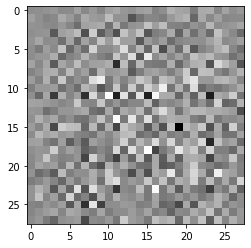

In [41]:
plt.imshow(imagem_gerada[0,:,:,0], cmap='gray')

#Build Discriminator:

In [46]:
def create_discriminator():
  network = tf.keras.Sequential()
  
  network.add(layers.Conv2D(filters=64, strides=(2,2), kernel_size=(5,5), padding='same', input_shape=(28,28,1)))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(.3))

  network.add(layers.Conv2D(filters=128, strides=(2,2), kernel_size=(5,5), padding='same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(.3))

  network.add(layers.Flatten())

  network.add(layers.Dense(1, activation='sigmoid'))

  network.summary()
  return network


In [47]:
discriminator = create_discriminator()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_5 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_2 (Flatten)         (None, 6272)             

In [48]:
discriminator(imagem_gerada, training=False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.5002086]], dtype=float32)>

#Calculo de erro:
(Real images label = 1; fake image label=0)

In [49]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [50]:
def discriminator_loss(expected_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(expected_output), expected_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

  total_loss = real_loss + fake_loss
  
  return total_loss

In [52]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [56]:
generator_optimizier = tf.keras.optimizers.Adam(learning_rate=1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)